In [1]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics

In [2]:
#accurate dynamics

#epc is the current epoch (current time), and x is the state

#accurate dynamics. considers gravity, J2, drag, solar radiation
#pressure, and the effect of other bodies (sun/moon)

#ẋ = f(x,t)
function ground_truth_dynamics(x, epc)
    
    r = x[1:3] #satellite position in inertial frame
    v = x[4:6] #satellite velocity in inertial frame
        
    #gives a rotation matrix
    PN = bias_precession_nutation(epc)
    
    #Compute the sun and moon positions in ECI frame
    r_sun = sun_position(epc)
    r_moon = moon_position(epc)
    
    #define the acceleration variable
    a = zeros(eltype(x), 3)
    
    #compute acceleration caused by Earth gravity (includes J2)
    #modeled by a spherical harmonic gravity field
    #look up this term. seems to give a rotation matrix
    PN = bias_precession_nutation(epc)
    Earth_r = earth_rotation(epc)
    rpm  = polar_motion(epc) 

    R = rpm*Earth_r*PN
    #10th order gravity
    n_grav = 10
    m_grav = 10
    #main contribution in acceleration (seemed to not be equal to the Series Expansion of gravity)
    a+= accel_gravity(x, R, n_grav, m_grav)
    
    a_grav = accel_gravity(x, R, n_grav, m_grav)
    
    #this is the gravity code that is used to find the difference between higher order model and J2 model 
    ###########################################################################################################
    #compute the gravitational acceleration based off the series expansion up to J2
    μ = 3.986004418e14 #m3/s2
    J2 = 1.08264e-3 
        
    a_2bp = (-μ*r)/(norm(r))^3
    
    Iz = [0,0,1]
    
    a_J2 = ((3*μ*J2*R_EARTH^2)/(2*norm(r)^5))*((((5*dot(r, Iz)^2)/norm(r)^2)-1)*r - 2*dot(r,Iz)*Iz)     

    a_process = a_2bp + a_J2
    
    #this is actual higher order
    higher_order_unmodeled = a_grav - a_process
    ############################################################################################################
    
    
    
    
    #atmospheric drag using true of date coordinate system
    ############################################################################################################
    #atmospheric drag
    #compute the atmospheric density from density harris priester model
     ρ_est = density_harris_priester(epc,r)

     #ρ = 1.15e-12 #fixed atmospheric density in kg/m3
    
     k_ρ_true = 1.0
     #sinusoidal
     #k_ρ_true = 0.1*sin(0.001*(epc-epc0))+1
    
     ρ_true = ρ_est*k_ρ_true
    
     #computes acceleration due to drag in inertial directions
     cd = 2.0 #drag coefficient
     area_drag = 0.1 #in m2 #area normal to the velocity direction
     m = 1.0 #assuming unit mass
    
     #drag from satellite dynamics.jl
     a += accel_drag(x, ρ_true, m, area_drag, cd, Array{Real,2}(PN))
###############################################################################################################
    
    
    #drag in ECI coordinates
    
    ##########################################3
    
    #k_ρ = 1.1
    
    #drag equation
    #c_d = 2.0 #drag coefficient (dimensionless)
    
    #A = 0.1  #cross sectional area
    
    #rotation of the earth (rad/s)
    #ω_earth = [0,0, OMEGA_EARTH]
    
    #v_rel = v - cross(ω_earth, r)
    
    #set a constant atmospheric density
    #ρ_est = density_harris_priester(epc,r)
    
    #f_drag = -0.5*c_d*(A)*k_ρ*ρ_est*norm(v_rel)*v_rel
    
    #a+= f_drag
    ##########################################
    
    #Solar Radiation Pressure
    area_srp = 1.0
    coef_srp = 1.8
    a += accel_srp(x, r_sun, m, area_srp, coef_srp)
    a_srp = accel_srp(x, r_sun, m, area_srp, coef_srp)
    
    #acceleration due to external bodies
    a+= accel_thirdbody_sun(x, r_sun)
    a_sun = accel_thirdbody_sun(x, r_sun)
    
    a+= accel_thirdbody_moon(x, r_moon)
    a_moon = accel_thirdbody_moon(x, r_moon)
    
    #commented out higher order gravities
    a_unmodeled = a_srp + a_sun + a_moon + higher_order_unmodeled
            
    xdot = x[4:6]
    vdot = a
    
    x_dot = [xdot; vdot]
    
    return x_dot, a_unmodeled, higher_order_unmodeled, ρ_est 
    
end

ground_truth_dynamics (generic function with 1 method)

In [3]:
#initial time for sim
epc0 = Epoch(2012, 11, 8, 12, 0, 0, 0.0)

Epoch(2012-11-08T11:59:25.000Z)

In [4]:
#wildlife tracking orbit
iss1 = [6871e3, 0.0004879, 90.6391, 194.5859, 151.2014, 190]; 

# Convert osculating elements to Cartesean state
# returns position and velocity (m, m/s). This is the intial position
eci0_1 = sOSCtoCART(iss1, use_degrees=true)

#find the period of the orbit (seconds). only dependent on semi major axis
T = orbit_period(iss1[1])

#final time of simulation
epcf = epc0 + T

Epoch(2012-11-08T13:33:53.144Z)

In [5]:
#testing hand-tuned Q
pose_std_dynamics = 3e-5 #these pose and velocity values are pretty good
velocity_std_dynamics = 0.5e-5
kp_a = 2e-5
kp_Q = 5e-2
βQ = 2.25e-3

Q = I(13).*[ones(3)*(pose_std_dynamics^2)/3; ones(3)*(velocity_std_dynamics^2)/3; (ones(3)*kp_a^2)/3; kp_Q^2; (ones(3)*βQ^2)/3]

13×13 Matrix{Float64}:
 3.0e-10  0.0      0.0      0.0          …  0.0        0.0        0.0
 0.0      3.0e-10  0.0      0.0             0.0        0.0        0.0
 0.0      0.0      3.0e-10  0.0             0.0        0.0        0.0
 0.0      0.0      0.0      8.33333e-12     0.0        0.0        0.0
 0.0      0.0      0.0      0.0             0.0        0.0        0.0
 0.0      0.0      0.0      0.0          …  0.0        0.0        0.0
 0.0      0.0      0.0      0.0             0.0        0.0        0.0
 0.0      0.0      0.0      0.0             0.0        0.0        0.0
 0.0      0.0      0.0      0.0             0.0        0.0        0.0
 0.0      0.0      0.0      0.0             0.0        0.0        0.0
 0.0      0.0      0.0      0.0          …  1.6875e-6  0.0        0.0
 0.0      0.0      0.0      0.0             0.0        1.6875e-6  0.0
 0.0      0.0      0.0      0.0             0.0        0.0        1.6875e-6

In [6]:
function satRK4(x, tc)
    
    f1,_,_, _ = ground_truth_dynamics(x, tc) 
    f2,_,_, _ = ground_truth_dynamics(x+0.5*h*f1, tc+h/2)
    f3,_,_, _ = ground_truth_dynamics(x+0.5*h*f2, tc+h/2)
    f4,_,_, _ = ground_truth_dynamics(x+h*f3, tc+h)
    
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)
            
    return xnext
    
end

satRK4 (generic function with 1 method)

In [7]:
#timestep
h = 1

#initial state
x_0 = eci0_1

#number of orbits to simulate
orbit_num = 5

#final time
Tf = T*orbit_num

#run the rk4
t = Array(range(0,Tf, step=h)) #create a range to final time at constant time step
    
all_x = zeros(length(x_0), length(t)) #variable to store all x
#all_fdrag = zeros(3, length(t))

all_x[:,1] = x_0 #set the initial state


for k=1:(length(t) - 1)

    #get the current time
    current_t = epc0+t[k]
    
    all_x[:,k+1] = satRK4(all_x[:,k], current_t) #calculate the next state

end

#contains all the ground truth states
x_hist = all_x

6×28341 Matrix{Float64}:
    -6.29129e6     -6.29368e6     -6.29606e6  …     -6.30433e6     -6.30667e6
    -1.66265e6     -1.66319e6     -1.66372e6        -1.66896e6     -1.66949e6
    -2.21616e6     -2.20895e6     -2.20174e6        -2.17387e6     -2.16665e6
 -2394.97       -2387.24       -2379.52          -2349.05       -2341.31
  -540.153       -538.111       -536.069          -529.386       -527.337
  7206.15        7208.88        7211.59       …   7222.06        7224.73

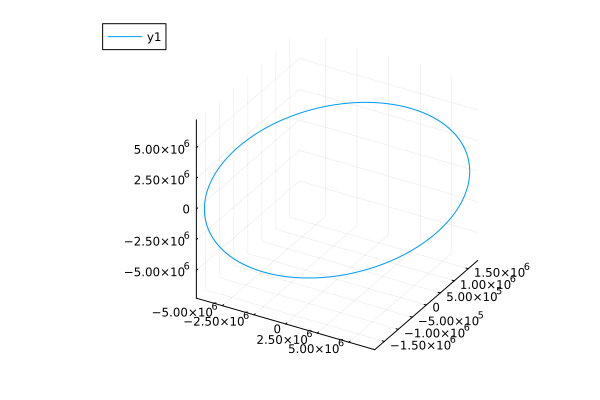

In [8]:
using Plots

plot(all_x[1,:], all_x[2,:], all_x[3,:])

In [9]:
#define GPS standard deviation

std_gps_measurement = 10 #10 meters 

#assume that the measurment noise i/s additive
R = Matrix(1.0I, 3, 3) *((std_gps_measurement)^2)/3

3×3 Matrix{Float64}:
 33.3333   0.0      0.0
  0.0     33.3333   0.0
  0.0      0.0     33.3333

In [10]:
#use gps mesurements from the txt file to be consistent
using DelimitedFiles
GPS_measurements = readdlm("gps_measurements.txt", '\t')

3×28341 Matrix{Float64}:
 -6.29129e6  -6.29367e6  -6.29606e6  …  -6.30198e6  -6.30434e6  -6.30666e6
 -1.66265e6  -1.66319e6  -1.66373e6     -1.66843e6  -1.66896e6  -1.66948e6
 -2.21616e6  -2.20896e6  -2.20173e6     -2.1811e6   -2.17387e6  -2.16665e6

In [11]:
#Generate GPS Measurments
# GPS_num = size(x_hist)[2]

# GPS_measurements = zeros(3, GPS_num)

# for i in 1:GPS_num
    
#     GPS_measurements[:, i] = x_hist[1:3, i] + sqrt(R)*randn(3)
    
# end


In [12]:
#the difference should be within close to the standard deviation set 
GPS_measurements - x_hist[1:3, :]

3×28341 Matrix{Float64}:
 -6.49993      8.30508  -0.930093  3.68528  …   1.45327  -10.262     9.72683
 -0.0680891   -4.40172  -1.75989   4.29732     -6.2286    -0.602747  3.79153
 -3.2824     -13.0184    8.01295   8.5173      -5.53958   -1.37874   0.94678

In [13]:
#using DelimitedFiles
#save gps measurements to a txt
#writedlm("gps_measurements.txt", GPS_measurements)

In [14]:
GPS_measurements

3×28341 Matrix{Float64}:
 -6.29129e6  -6.29367e6  -6.29606e6  …  -6.30198e6  -6.30434e6  -6.30666e6
 -1.66265e6  -1.66319e6  -1.66373e6     -1.66843e6  -1.66896e6  -1.66948e6
 -2.21616e6  -2.20896e6  -2.20173e6     -2.1811e6   -2.17387e6  -2.16665e6

In [15]:
#estimated GPS measurment given the estimated state (deterministic) 
function measurment_function(x)
    
    C = [I zeros((3,9))]
    #measurment only gives you the position of the satellite
    measurment = C*x 
    
    #only return the state of the spacecraft
    return measurment, C
end

measurment_function (generic function with 1 method)

In [16]:
#jacobian of the measurment function
H = [I zeros((3,9))]

3×12 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [17]:
function process_dynamics(x, epc)
   
    #position
    q = x[1:3]
    v = x[4:6]
    a_d = x[7:9]
    β = x[10:12]
    
    k_ρ = 1
    
    #drag equation
    c_d = 2.0 #drag coefficient (dimensionless)
    
    A = 0.1  #cross sectional area
    
    #rotation of the earth (rad/s)
    ω_earth = [0,0, OMEGA_EARTH]
    
    v_rel = v - cross(ω_earth, q)
    
    #set a constant atmospheric density
    ρ_est = density_harris_priester(epc,q)

    #println("rho est: ")
    #println(ρ_est)

    #for testing
    ρ_est = 1e-13
    
    f_drag = -0.5*c_d*(A)*k_ρ*ρ_est*norm(v_rel)*v_rel

    
    μ = 3.986004418e14 #m3/s2
    J2 = 1.08264e-3 
        
    a_2bp = (-μ*q)/(norm(q))^3
    
    Iz = [0,0,1]
    
    a_J2 = ((3*μ*J2*R_EARTH^2)/(2*norm(q)^5))*((((5*dot(q, Iz)^2)/norm(q)^2)-1)*q - 2*dot(q,Iz)*Iz)   
    
    a = a_2bp + a_J2 + f_drag + a_d
    
    #First Order gauss process
    a_d_dot = -diagm(β)*a_d

    x_dot = [v;a; a_d_dot; zeros(3)]
    
    return x_dot
    
end

process_dynamics (generic function with 1 method)

In [19]:
function RK4_process_dynamics(x, tc)
    
    f1= process_dynamics(x, tc) 
    f2 = process_dynamics(x+0.5*h*f1,tc+h/2)
    f3 = process_dynamics(x+0.5*h*f2, tc+h/2)
    f4 = process_dynamics(x+h*f3, tc+h)
    
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)
        
    return xnext
    
end

RK4_process_dynamics (generic function with 1 method)

In [20]:
RK4_process_dynamics(X_0, epc0)

UndefVarError: UndefVarError: X_0 not defined

In [21]:
#do a forward rollout with the process dynamics model

#if we just trust our dynamics, we get about a 100 meter error in position from the 
#ground truth at the end of the 5 orbits 

x_0_new = [x_0; 1e-6; 1e-6; 1e-6; 0; 0; 0]

all_x_est = zeros(length(x_0_new), length(t)) #variable to store all x
    
all_x_est[:,1] = x_0_new #set the initial state

for k=1:(length(t) - 1)
            
    current_t = epc0+t[k] #calculate the current time
        
    all_x_est[:,k+1] = RK4_process_dynamics(all_x_est[:,k], current_t) #calculate the next state
        
end


In [22]:
#if we were to just trust the dynamics, we would be off by a significant amount at the end of the trajectory
all_x_est[1:6,:] - x_hist

6×28341 Matrix{Float64}:
 0.0   1.188e-5     4.73894e-5   0.000106333  …    464.783       463.254
 0.0   7.3947e-6    2.95085e-5   6.62364e-5        196.274       196.011
 0.0  -8.82708e-6  -3.53768e-5  -7.97501e-5      -1209.77      -1210.14
 0.0   2.37269e-5   4.72588e-5   7.05955e-5         -1.52867      -1.52891
 0.0   1.47718e-5   2.94382e-5   4.4e-5             -0.262635     -0.262827
 0.0  -1.76715e-5  -3.54449e-5  -5.3319e-5    …     -0.369524     -0.367976

In [23]:
zeros(size(t)[1])

28341-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [24]:
#find the magnitude of the unmodeled accelerations
unmodeled_accelerations = zeros(3, size(t)[1])

atmospheric_density = zeros(size(t)[1])
higher_order_accelerations = zeros(3, size(t)[1])

count = 0

for i in t
    count += 1
    current_t = epc0+t[count]
    
    _ ,unmodeled_accelerations[:,count], higher_order_accelerations[:,count], atmospheric_density[count] = ground_truth_dynamics(x_hist[:,count], current_t)
    
end

In [25]:
atmospheric_density

#writedlm("atm_density.txt", atmospheric_density)

28341-element Vector{Float64}:
 1.1893619978573765e-12
 1.1893825700649655e-12
 1.1894016641026052e-12
 1.1894192792149244e-12
 1.189435414655462e-12
 1.1894500696868626e-12
 1.1894632435808916e-12
 1.1894749356091998e-12
 1.1894851450799526e-12
 1.1894938712830583e-12
 ⋮
 1.1837857633793826e-12
 1.1838079933796069e-12
 1.1838287624947723e-12
 1.1838480699828717e-12
 1.1838659150834827e-12
 1.1838822970542135e-12
 1.1838972151616075e-12
 1.1839106686812078e-12
 1.183922656897467e-12

In [26]:
hours_ua = size(unmodeled_accelerations)[2]/60/60

hours_scale_ua = LinRange(0, hours_ua, size(unmodeled_accelerations)[2]) 

#hours_scale_t = vcat(hours_scale)

28341-element LinRange{Float64}:
 0.0,0.000277788,0.000555575,0.000833363,…,7.87167,7.87194,7.87222,7.8725

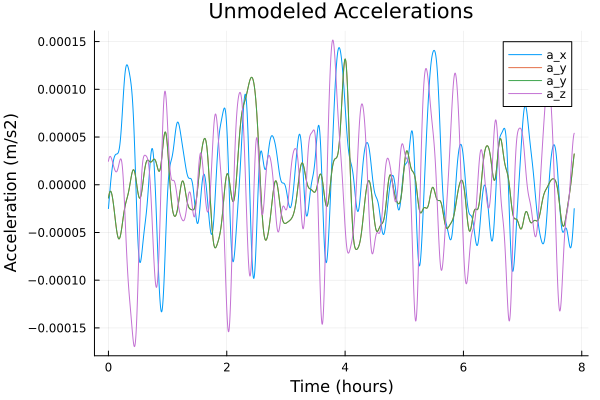

In [27]:
plot(hours_scale_ua,unmodeled_accelerations[1,:], xlabel= "Time (hours)", ylabel="Acceleration (m/s2)", label="a_x")
plot!(hours_scale_ua,unmodeled_accelerations[2,:], label="a_y", title="Higher Order Accelerations")
plot!(hours_scale_ua,unmodeled_accelerations[2,:], label="a_y", title="Unmodeled Accelerations")
plot!(hours_scale_ua,unmodeled_accelerations[3,:], label="a_z")

#savefig("unmodeled_accel_hours_nohighorder.png")

In [28]:
#plotting script for higher order accel.
# plot(hours_scale_ua,higher_order_accelerations[1,:], xlabel= "Time (hours)", ylabel="Acceleration (m/s2)", label="a_x")
# plot!(hours_scale_ua,higher_order_accelerations[2,:], label="a_y", title="Higher Order Accelerations")
# plot!(hours_scale_ua,higher_order_accelerations[2,:], label="a_y", title="Unmodeled Accelerations")
# plot!(hours_scale_ua,higher_order_accelerations[3,:], label="a_z")

# #savefig("unmodeled_accel_hours_nohighorder.png")

In [29]:
#plot(higher_order_accelerations[1,:])
#plot!(higher_order_accelerations[2,:])
#plot!(higher_order_accelerations[3,:])

In [42]:
#find the discrete dynamics jacobian of the process model
function find_jacobian_discrete(x_0, tc)
    
    F = ForwardDiff.jacobian(dx -> RK4_process_dynamics(dx, tc), x_0)
    
    return F

end

find_jacobian_discrete (generic function with 1 method)

In [43]:
#hand tuned values for process noise
q_βx, q_βy, q_βz = 2e-9*ones(3) 
q_ϵx,q_ϵy,q_ϵz = 5.5e-11*ones(3)

3-element Vector{Float64}:
 5.5e-11
 5.5e-11
 5.5e-11

In [44]:
#SQRT QR EKF Formulation 
function EKF_satellite_QR(X, F, k, tc)
    
    print("running QR")
    #the betas
    βx, βy, βz = X[10:12] 
    
    V_ = 1.0*Matrix(I,3,3).*[q_ϵx*(1-exp(-2*βx*h))/(2*βx); q_ϵy*(1-exp(-2*βy*h))/(2*βy); q_ϵz*(1-exp(-2*βz*h))/(2*βz)]
    
    Y_ = h*1.0*Matrix(I,3,3).*[q_βx; q_βy; q_βz]
    
    #this is the process noise for this step. From the Myers paper 
    Qt_full = [0.25*(h^4)*V_ 0.5*(h^3)*V_ 0.5*(h^2)*V_ zeros(3,3); 
          0.5*(h^3)*V_ h^2*V_ h*V_ zeros(3,3); 
          0.5*(h^2)*V_ h*V_ V_ zeros(3,3); 
          zeros(3,9) Y_]

    Qt = 1.0*Matrix(I,12,12).*diag(Qt_full)
    
    #print("diag of qt full")
    
    #println(diag(Qt_full))
    #Prediction Step
    
    #state prediction
    X_pre = RK4_process_dynamics(X, tc)

    println("x prediction")

    println(X_pre)

    A = find_jacobian_discrete(X, tc) #the A matrix from the dynamics

    #the process noise matrix
    #println("process noise matrix")
    #println(Qt)

    #println("sqrt process noise matrix")
    #println(sqrt(Qt))


    n = [F*A'; sqrt(Qt)]
    
    _, F_pre = qr(n)
            
    zk̂, C = measurment_function(X_pre) #get the measurment from the state prediction
        
    innovation = GPS_measurements[1:3, k+1] - zk̂

    m = [F_pre*C';sqrt(R)]
    
    _, G = qr(m) #mxm where m is measurement size
    
    L_inside = G\((G'\C)*F_pre'*F_pre)
    
    L = L_inside'  
        
    X = X_pre + L*innovation
    
    _, F = qr([F_pre*(I-L*C)'; sqrt(R)*L'])
    
    return X, F
    
end

EKF_satellite_QR (generic function with 1 method)

In [45]:
#testing first state 
#Initial State and Initial Covariance 
#uncertainty much higher in the velocity becasue there is no measuerment to update the prediction!

true_first_pose = eci0_1

std_gps_measurement= 10 #10 meters
GPS_num = size(x_hist)[2]
gps_noise = randn(3)*10/3
velocity_noise = randn(3)*0.001 

std_velocity = 0.01

#X_0 = [true_first_pose[1]+gps_noise[1],true_first_pose[2]+gps_noise[2],true_first_pose[3]+gps_noise[3],true_first_pose[4]+velocity_noise[1],true_first_pose[5]+velocity_noise[2],true_first_pose[6]+velocity_noise[3], 0, 0, 0,1e-3, 1e-3, 1e-3]

#doing all the testing with the X_0
X_0 = [    -6.291282146358055e6
-1.6626488883220146e6
-2.2161533651363864e6
-2394.9723284619768
-540.1536627486031
7206.153483511754
 0.0
 0.0
 0.0
 0.001
 0.001
 0.001]
P_0 = I(12).*[ones(3)*((std_gps_measurement)^2)/3; ones(3)*((std_velocity)^2)/3; ones(3)*5e-4^2; ones(3)*4e-4^2]

#take the cholesky factorization
F_0 = sqrt(P_0)

all_states = zeros(12, GPS_num)

cov_sqrt_all = [zeros(12, 12) for i in 1:GPS_num];

#set first value to X_0
all_states[:,1] = X_0

cov_sqrt_all[1] = F_0 

X_pre = RK4_process_dynamics(X_0, epc0)

A = find_jacobian_discrete(X_0, epc0) #the A matrix from the dynamics

    #the process noise matrix
    #println("process noise matrix")
    #println(Qt)

    #println("sqrt process noise matrix")
    #println(sqrt(Qt))


    n = [F_0*A'; sqrt(Qt)]
    
    _, F_pre = qr(n)

zk̂, C = measurment_function(X_pre) #get the measurment from the state prediction
        
innovation = GPS_measurements[1:3, 2] - zk̂

m = [F_pre*C';sqrt(R)]
    
_, G = qr(m) #mxm where m is measurement size

L_inside = G\((G'\C)*F_pre'*F_pre)
    
L = L_inside'  

X = X_pre + L*innovation
    
    _, F = qr([F_pre*(I-L*C)'; sqrt(R)*L'])

display(X)

12-element Vector{Float64}:
    -6.293670722492918e6
    -1.6631898292000196e6
    -2.2089540032679434e6
 -2387.246110230014
  -538.1118479489946
  7208.877754502538
     9.487342493179311e-9
    -6.771214807802831e-9
    -3.053858820410833e-8
     0.001
     0.001
     0.001

In [46]:
X_0

12-element Vector{Float64}:
    -6.291282146358055e6
    -1.6626488883220146e6
    -2.2161533651363864e6
 -2394.9723284619768
  -540.1536627486031
  7206.153483511754
     0.0
     0.0
     0.0
     0.001
     0.001
     0.001

In [47]:
X_pre = RK4_process_dynamics(X_0, epc0)

12-element Vector{Float64}:
    -6.293673255823721e6
    -1.6631880211332443e6
    -2.208945848779449e6
 -2387.2461071157563
  -538.1118476812146
  7208.877753546626
     0.0
     0.0
     0.0
     0.001
     0.001
     0.001

In [48]:
h

1

In [49]:
print("running QR")
#the betas
βx, βy, βz = X_0[10:12] 
    
V_ = 1.0*Matrix(I,3,3).*[q_ϵx*(1-exp(-2*βx*h))/(2*βx); q_ϵy*(1-exp(-2*βy*h))/(2*βy); q_ϵz*(1-exp(-2*βz*h))/(2*βz)]
    
Y_ = h*1.0*Matrix(I,3,3).*[q_βx; q_βy; q_βz]
    
#this is the process noise for this step. From the Myers paper 
Qt_full = [0.25*(h^4)*V_ 0.5*(h^3)*V_ 0.5*(h^2)*V_ zeros(3,3); 
        0.5*(h^3)*V_ h^2*V_ h*V_ zeros(3,3); 
        0.5*(h^2)*V_ h*V_ V_ zeros(3,3); 
        zeros(3,9) Y_]

Qt = 1.0*Matrix(I,12,12).*diag(Qt_full)
    
#print("diag of qt full")
    
#println(diag(Qt_full))
#Prediction Step
    
#state prediction
X_pre = RK4_process_dynamics(X_0, epc0)

println("x prediction")

println(X_pre)

A = find_jacobian_discrete(X_0, epc0) #the A matrix from the dynamics

#the process noise matrix
#println("process noise matrix")
#println(Qt)

#println("sqrt process noise matrix")
#println(sqrt(Qt))


n = [F_0*A'; sqrt(Qt)]
    
 _, F_pre = qr(n)

diag(F_pre)

running QRx prediction
[-6.293673255823721e6, -1.6631880211332443e6, -2.208945848779449e6, -2387.2461071157563, -538.1118476812146, 7208.877753546626, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001]


12-element Vector{Float64}:
 -5.773510947815556
 -5.773502661716965
 -5.773503142638224
 -0.005795087798333395
 -0.005795096094826954
 -0.005795095612910885
 -0.000497694650118001
 -0.0004976946518877244
 -0.0004976946517847423
 -0.00040249223594996216
 -0.00040249223594996216
 -0.00040249223594996216

In [50]:
all_states[:,1]

12-element Vector{Float64}:
    -6.291282146358055e6
    -1.6626488883220146e6
    -2.2161533651363864e6
 -2394.9723284619768
  -540.1536627486031
  7206.153483511754
     0.0
     0.0
     0.0
     0.001
     0.001
     0.001

In [51]:
print("done")

done

In [53]:
#run EKF for every time step

#for k=1:GPS_num-1
for k=1:3
        
    tc = epc0+t[k]
    
    #obtain the updated and state at the next timestep
    X, F = EKF_satellite_QR(all_states[:,k], cov_sqrt_all[k], k, tc)
    
    all_states[:,k+1] = X
    
    cov_sqrt_all[k+1] = F
    
end
    

running QRx prediction
[-6.293673255823721e6, -1.6631880211332443e6, -2.208945848779449e6, -2387.2461071157563, -538.1118476812146, 7208.877753546626, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001]
running QRx prediction
[-6.296054104257485e6, -1.663726919860007e6, -2.201743767066481e6, -2379.5169247302147, -536.0693604148086, 7211.59317103183, 9.47785989277655e-9, -6.764446977474178e-9, -3.0508064880109833e-8, 0.001, 0.001, 0.001]
running QRx prediction
[-6.298431988826684e6, -1.6642616896587545e6, -2.1945265281203813e6, -2371.784783620554, -534.0262062306687, 7214.299716732266, -4.894620721319917e-8, 5.143225085324329e-10, 8.177059858806956e-8, 0.0010000000000000343, 0.001000000000000003, 0.0010000000000002123]


In [55]:
all_states[:,3]

12-element Vector{Float64}:
    -6.296056337723554e6
    -1.6637266418193919e6
    -2.201739475303808e6
 -2379.5169300559915
  -536.0693613041161
  7211.593172155257
    -4.8995177901675714e-8
     5.148370882879615e-10
     8.185241008558878e-8
     0.0010000000000000343
     0.001000000000000003
     0.0010000000000002123

In [49]:
all_states[:,2]

12-element Vector{Float64}:
    -6.293670722492918e6
    -1.6631898292000196e6
    -2.2089540032679434e6
 -2387.246110230014
  -538.1118479489946
  7208.877754502538
     9.487342493179311e-9
    -6.771214807802831e-9
    -3.053858820410833e-8
     0.001
     0.001
     0.001

In [43]:
#write all states to a txt file
#writedlm("all_states.txt", all_states)

#write all sqrt covarainces to a txt file
#writedlm("cov_sqrt_all.txt", cov_sqrt_all)

In [133]:
#Covariance Analysis

R_end = cov_sqrt_all[end]

sigma_end = R_end'*R_end

#final position standard deviation
sat_final_std = sqrt(tr(sigma_end[1:3, 1:3])) 

println("This is the final position accuracy of the GPS EKF")
display(sat_final_std)

sat_std_x = sqrt(sigma_end[1,1]);
sat_std_y = sqrt(sigma_end[2,2]);
sat_std_z = sqrt(sigma_end[3,3]);

println("Sat std x: ")
display(sat_std_x)

println("Sat std y: ")
display(sat_std_y)

println("Sat std z: ")
display(sat_std_z)

0.0

0.0

0.0

0.0

In [134]:
all_states[:,45]

12-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
diag(cov_sqrt_all[45])

In [ ]:
plot(all_states[7,1:140])

In [ ]:
display(all_states[7:9, 519])

In [ ]:
display(all_states[10:12, 519])

In [ ]:
sat_final_std_vel = sqrt(tr(sigma_end[4:6, 4:6])) 

In [ ]:
sat_final_std_ad = sqrt(tr(sigma_end[7:9, 7:9])) 

In [ ]:
#Final difference L2 norm
final_diff = norm(x_hist[:,end] - all_states[1:6,end])

In [ ]:
#Final difference L1 norm
final_diff_L1 = x_hist[:,end] - all_states[1:6,end]

In [ ]:
x_hist[:,end] - all_states[1:6, end]

In [ ]:
σx = R_end[1,1]
σy = R_end[2,2]
σz = R_end[3,3]
σvx = R_end[4,4]
σvy = R_end[5,5]
σvz = R_end[6,6]
σax = R_end[7,7]
σay = R_end[8,8]
σaz = R_end[9,9]

In [ ]:
N=length(t)

In [ ]:
#save all the standard deviations in a matrix to test filter consistency
all_x_std = zeros(N)
all_y_std = zeros(N)
all_z_std = zeros(N)
all_vx_std = zeros(N)
all_vy_std = zeros(N)
all_vz_std = zeros(N)
all_ax_std = zeros(N)
all_ay_std = zeros(N)
all_az_std = zeros(N)

for i=1:N

    all_x_std[i] = cov_sqrt_all[i][1,1]
    all_y_std[i] = cov_sqrt_all[i][2,2]
    all_z_std[i] = cov_sqrt_all[i][3,3]
    all_vx_std[i] = cov_sqrt_all[i][4,4]
    all_vy_std[i] = cov_sqrt_all[i][5,5]
    all_vz_std[i] = cov_sqrt_all[i][6,6]
    all_ax_std[i] = cov_sqrt_all[i][7,7]
    all_ay_std[i] = cov_sqrt_all[i][8,8]
    all_az_std[i] = cov_sqrt_all[i][9,9]
    
end

In [ ]:
#initial difference
initial_diff = norm(x_hist[:,1] - all_states[1:6,1])

In [ ]:
plot(unmodeled_accelerations[1,:])
plot!(all_states[7,:])

In [ ]:
all_states[7,1:1000]

In [ ]:
#residuals between the estimated state and the true state

res1 = x_hist[1,:] - all_states[1,:]
res2 = x_hist[2,:] - all_states[2,:]
res3 = x_hist[3,:] - all_states[3,:]
res4 = x_hist[4,:] - all_states[4,:]
res5 = x_hist[5,:] - all_states[5,:]
res6 = x_hist[6,:] - all_states[6,:]
res7 = unmodeled_accelerations[1,:] - all_states[7,:]
res8 = unmodeled_accelerations[2,:]- all_states[8,:]
res9 = unmodeled_accelerations[3,:] - all_states[9,:]

In [ ]:
N=length(t)

In [ ]:
#get units of hours to make the units better
hours = size(res1)[1]/60/60

hours_scale = LinRange(0, hours, size(res1)[1]) 

hours_scale_t = vcat(hours_scale)

In [ ]:
sub = LinRange(1, size(hours_scale_t)[1], 2000)

In [ ]:
sub_int = round.(Int, sub)

In [ ]:
sub_hours = zeros(size(sub_int)[1])
sub_res1 = zeros(size(sub_int)[1])
sub_res2 = zeros(size(sub_int)[1])
sub_res3 = zeros(size(sub_int)[1])
sub_res4 = zeros(size(sub_int)[1])
sub_res5 = zeros(size(sub_int)[1])
sub_res6 = zeros(size(sub_int)[1])
sub_res7 = zeros(size(sub_int)[1])
sub_res8 = zeros(size(sub_int)[1])
sub_res9 = zeros(size(sub_int)[1])
sub_xstd = zeros(size(sub_int)[1])
sub_ystd = zeros(size(sub_int)[1])
sub_zstd = zeros(size(sub_int)[1])
sub_vxstd = zeros(size(sub_int)[1])
sub_vystd = zeros(size(sub_int)[1])
sub_vzstd = zeros(size(sub_int)[1])
sub_axstd = zeros(size(sub_int)[1])
sub_aystd = zeros(size(sub_int)[1])
sub_azstd = zeros(size(sub_int)[1])

In [ ]:
b = 3.4245675

typeof(b)

c = round(b, digits=3)

In [ ]:
A = [[1.37362592e-11 0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.37362592e-11 0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.37362592e-11 0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.74725183e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.74725183e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.74725183e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 5.49450366e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-09 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-09]]



In [ ]:
display(diag(A))

In [ ]:
diag(A)

In [ ]:
isposdef(A)

In [ ]:
a_sqrt = sqrt(A)

In [ ]:
a_sqrt*a_sqrt

In [ ]:
#create a subset due to memory requirements in overleaf
count = 0
for i in sub_int
    count += 1
    sub_hours[count] = hours_scale_t[i]
    sub_res1[count] = res1[i]
    sub_res2[count] = res2[i]
    sub_res3[count] = res3[i]
    sub_res4[count] = res4[i]
    sub_res5[count] = res5[i]
    sub_res6[count] = res6[i]
    sub_res7[count] = res7[i]
    sub_res8[count] = res8[i]
    sub_res9[count] = res9[i]
    
    sub_xstd[count] = all_x_std[i]
    sub_ystd[count] = all_y_std[i]
    sub_zstd[count] = all_z_std[i]
    sub_vxstd[count] = all_vx_std[i]
    sub_vystd[count] = all_vy_std[i]
    sub_vzstd[count] = all_vz_std[i]
    sub_axstd[count] = all_ax_std[i]
    sub_aystd[count] = all_ay_std[i]
    sub_azstd[count] = all_az_std[i]
    
end


#round to 5 digits for memory in overleaf
sub_hours = round.(sub_hours, digits=5)
sub_res1 = round.(sub_res1, digits=5)
sub_res2 = round.(sub_res2, digits=5)
sub_res3 = round.(sub_res3, digits=5)
sub_res4 = round.(sub_res4, digits=5)
sub_res5 = round.(sub_res5, digits=5)
sub_res6 = round.(sub_res6, digits=5)
sub_res7 = round.(sub_res7, digits=5)
sub_res8 = round.(sub_res8, digits=5)
sub_res9 = round.(sub_res9, digits=5)
sub_xstd = round.(sub_xstd, digits=5)
sub_ystd = round.(sub_ystd, digits=5)
sub_zstd = round.(sub_zstd, digits=5)
sub_vxstd = round.(sub_vxstd, digits=5)
sub_vystd = round.(sub_vystd, digits=5)
sub_vzstd = round.(sub_vzstd, digits=5)
sub_axstd = round.(sub_axstd, digits=5)
sub_aystd = round.(sub_aystd, digits=5)
sub_azstd = round.(sub_azstd, digits=5)

In [ ]:
#Plots for the residuals

In [ ]:
plot(sub_hours, sub_res1, label = "Residual", title = "X  Residual", xlabel = "Time (hours)", ylabel = "Distance (m)")
plot!(sub_hours,sub_xstd*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,sub_xstd*-3, lw=4, label = "3σ Lower Bound")
#savefig("xres_V4.png")

In [ ]:
#round function 
#sample a lot in the beginning (not uniform), then sample  

In [ ]:
plot(sub_hours,sub_res2, label = "Residual", title = "Y Residual", xlabel = "Time (hours)", ylabel = "Distance (m)")
plot!(sub_hours,sub_ystd*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,sub_ystd*-3, lw=4, label = "3σ Lower Bound")
#savefig("yres_V4.png")

In [ ]:
plot(sub_hours,sub_res3, label = "Residual", title = "Z Residual", xlabel = "Time (hours)", ylabel = "Distance (m)")
plot!(sub_hours,sub_zstd*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,sub_zstd*-3, lw=4, label = "3σ Lower Bound")
#savefig("zres_V4.png")

In [ ]:
plot(sub_hours,sub_res4, label = "Residual", title = "Vx Residual", xlabel = "Time (hours)", ylabel = "Velocity (m/s)")
plot!(sub_hours,abs.(sub_vxstd)*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,abs.(sub_vxstd)*-3, lw=4, label = "3σ Lower Bound")
#savefig("vxres_V4.png")

In [ ]:
plot(sub_hours,sub_res5, label = "Residual", title = "Vy Residual", xlabel = "Time (hours)", ylabel = "Velocity (m/s)")
plot!(sub_hours,abs.(sub_vystd)*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,abs.(sub_vystd)*-3, lw=4, label = "3σ Lower Bound")
#savefig("vyres_V4.png")

In [ ]:
plot(sub_hours,sub_res6, label = "Residual", title = "Vz Residual", xlabel = "Time (hours)", ylabel = "Velocity (m/s)")
plot!(sub_hours,abs.(sub_vzstd)*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,abs.(sub_vzstd)*-3, lw=4, label = "3σ Lower Bound")
#savefig("vzres_V4.png")

In [ ]:
plot(sub_hours,sub_res7, label = "Residual", title = "Ax Residual", xlabel = "Time (hours)", ylabel = "Acceleration (m/s2)")
plot!(sub_hours,abs.(sub_axstd)*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,abs.(sub_axstd)*-3, lw=4, label = "3σ Lower Bound")
#savefig("axres_V4.png")

In [ ]:
plot(sub_hours,sub_res8, label = "Residual", title = "Ay Residual", xlabel = "Time (hours)", ylabel = "Acceleration (m/s2)")
plot!(sub_hours,abs.(sub_aystd)*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,abs.(sub_aystd)*-3, lw=4, label = "3σ Lower Bound")
#savefig("ayres_V4.png")

In [ ]:
plot(sub_hours,sub_res9, label = "Residual", title = "Az Residual", xlabel = "Time (hours)", ylabel = "Acceleration (m/s2)")
plot!(sub_hours,abs.(sub_azstd)*3, lw=4, label = "3σ Upper Bound")
plot!(sub_hours,abs.(sub_azstd)*-3, lw=4, label = "3σ Lower Bound")
#savefig("azres_V4.png")

In [ ]:
#save all the files

using DelimitedFiles
#save hours scale
writedlm("sub_hours.txt", sub_hours)

In [ ]:
#save all the residuals
writedlm("sub_res1.txt", sub_res1)
writedlm("sub_res2.txt", sub_res2)
writedlm("sub_res3.txt", sub_res3)
writedlm("sub_res4.txt", sub_res4)
writedlm("sub_res5.txt", sub_res5)
writedlm("sub_res6.txt", sub_res6)
writedlm("sub_res7.txt", sub_res7)
writedlm("sub_res8.txt", sub_res8)
writedlm("sub_res9.txt", sub_res9)

In [ ]:
writedlm("subx_std.txt", sub_xstd)
writedlm("suby_std.txt", sub_ystd)
writedlm("subz_std.txt", sub_zstd)
writedlm("subvx_std.txt", sub_vxstd)
writedlm("subvy_std.txt", sub_vystd)
writedlm("subvz_std.txt", sub_vzstd)
writedlm("subax_std.txt", sub_axstd)
writedlm("subay_std.txt", sub_aystd)
writedlm("subaz_std.txt", sub_azstd)

In [ ]:
#Finding the RMSE

function RMSE(residuals)
    
   rmse = sqrt(sum(residuals.*residuals)/size(residuals)[1])
    
    return rmse
    
end

In [ ]:
res1[28000:end]

In [ ]:
rmse_x = RMSE(res1)
rmse_y = RMSE(res2)
rmse_z = RMSE(res3)
rmse_vx = RMSE(res4)
rmse_vy = RMSE(res5)
rmse_vz = RMSE(res6)
rmse_ax = RMSE(res7)
rmse_ay = RMSE(res8)
rmse_az = RMSE(res9)

println("RMSE x: ")
println(rmse_x)

println("RMSE y: ")
println(rmse_y)

println("RMSE z: ")
println(rmse_z)

println("RMSE vx: ")
println(rmse_vx)

println("RMSE vy: ")
println(rmse_vy)

println("RMSE vz: ")
println(rmse_vz)

println("RMSE ax: ")
println(rmse_ax)

println("RMSE ay: ")
println(rmse_ay)

println("RMSE az: ")
println(rmse_az)